# Trabajo LC

Jaume Ivars Grimalt e Iñaki Diez Lambies

#### Importaciones necesarias

In [237]:
import nltk
from nltk.corpus import cess_esp
from nltk.tag import hmm, tnt, AffixTagger, brill, brill_trainer, UnigramTagger, PerceptronTagger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
import scipy.stats as stats
from IPython.display import display
from sklearn.model_selection import train_test_split
import math

nltk.download("cess_esp")
cess_sents = list(cess_esp.tagged_sents()).copy()
np.random.shuffle(cess_sents)

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\NachoDíez\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


## Ejercicio 1

Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de
categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada
sobre 10 particiones del corpus. Barajar el corpus antes de realizar las particiones. Presentar los
resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

In [160]:
def show_accuracy_table(accuracies, title, labels, show_mean=True, show_ic=True):
    mean_acc = np.mean(accuracies)
    conf_int = stats.t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    
    data = {
        title: labels,
        "Accuracy": accuracies
    }

    if show_mean:
        data[title] += ["Mean"]
        data["Accuracy"] = data["Accuracy"] + [mean_acc]

    if show_ic:
        data[title] += ["Confidence interval"]
        data["Accuracy"] = data["Accuracy"] + [f"{conf_int[0]:.4f} - {conf_int[1]:.4f}"]

    df = pd.DataFrame(data)
    display(df)

In [266]:
def show_accuracy_graph(accuracies, title, labels, x_label, show_error_bars=True):
    plt.figure(figsize=(10, 5))

    acc_min = min(accuracies)
    acc_max = max(accuracies)
    acc_range = acc_max - acc_min
    margin = acc_range * 0.5
    
    plt.ylim(max(0, acc_min - margin), min(1, acc_max + margin))
    
    x = list(range(len(accuracies)))
    plt.plot(x, accuracies, 'ro-')
    
    plt.xticks(x, labels)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    
    if show_error_bars:
        conf_int = t.interval(0.95, len(accuracies)-1, loc=np.mean(accuracies), scale=stats.sem(accuracies))
        y_error = (conf_int[1] - conf_int[0]) / 2
        plt.errorbar(x, accuracies, yerr=y_error, linestyle='None', color='blue', capsize=5)
    
    plt.grid(True)
    plt.show()


In [240]:
def cross_validate_hmm(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for j, particion in enumerate(partitions) if j != i for sentence in particion]

        hmm_tagger = hmm.HiddenMarkovModelTagger.train(train_data)
        acc = hmm_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

### Con todas las categorías

Realizar experimentos

In [163]:
all_categories_accuracies = cross_validate_hmm(cess_sents, 10)

Accuracy for partition 0: 0.8978172999191593
Accuracy for partition 1: 0.8977349297672731
Accuracy for partition 2: 0.8955798231929277
Accuracy for partition 3: 0.9008422056252979
Accuracy for partition 4: 0.898283695103483
Accuracy for partition 5: 0.8943948847522302
Accuracy for partition 6: 0.8969331053643941
Accuracy for partition 7: 0.8966534431899095
Accuracy for partition 8: 0.8952680428057007
Accuracy for partition 9: 0.8984097576038289
Mean accuracy:  0.8971917187324205
Confidence interval:  (0.8958605193001101, 0.898522918164731)


Mostrar resultados

,Accuracy por fold,Accuracy
0,Fold 0,0.897817
1,Fold 1,0.897735
2,Fold 2,0.89558
3,Fold 3,0.900842
4,Fold 4,0.898284
5,Fold 5,0.894395
6,Fold 6,0.896933
7,Fold 7,0.896653
8,Fold 8,0.895268
9,Fold 9,0.89841


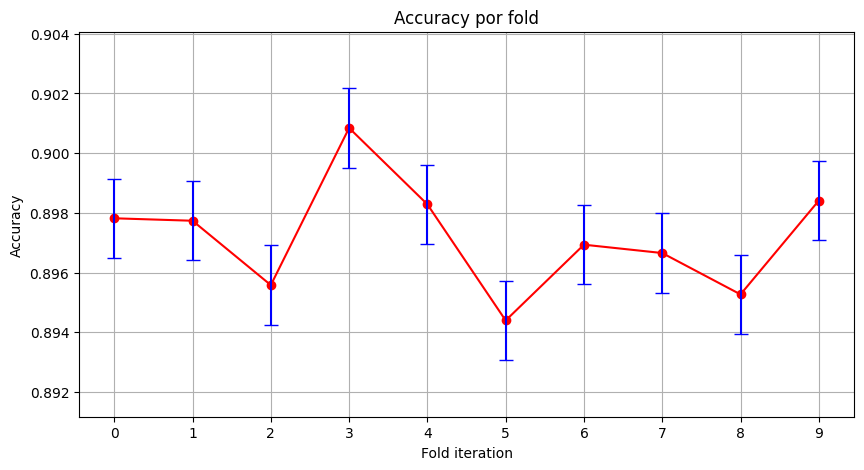

In [268]:
show_accuracy_table(all_categories_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(all_categories_accuracies, "Accuracy por fold", list(range(10)), "Fold iteration")

### Juego de categorías reducido
Preprocesado para reducir las categorías

In [165]:
reduced_cess_sents = []
for sentence in cess_sents:
    new_line = []
    for word, key in sentence:
        if word == "*0*" and key == "sn":
            continue
        elif key[0] == 'v' or key[0] == 'F':
            key = key[:3]
        else:
            key = key[:2]
        new_line.append((word,key))
    reduced_cess_sents.append(new_line)

Realizar experimento

In [166]:
reduced_categories_accuracies = cross_validate_hmm(reduced_cess_sents, 10)

Accuracy for partition 0: 0.9305308542171922
Accuracy for partition 1: 0.9313740734981599
Accuracy for partition 2: 0.9284451378055122
Accuracy for partition 3: 0.9317230785528895
Accuracy for partition 4: 0.9303382130237254
Accuracy for partition 5: 0.9249213633785387
Accuracy for partition 6: 0.930433853387476
Accuracy for partition 7: 0.9284915064591598
Accuracy for partition 8: 0.9262058122432418
Accuracy for partition 9: 0.9290823941125006
Mean accuracy:  0.9291546286678395
Confidence interval:  (0.9275725819360867, 0.9307366753995923)


Mostrar resultados

,Accuracy por fold,Accuracy
0,Fold 0,0.930531
1,Fold 1,0.931374
2,Fold 2,0.928445
3,Fold 3,0.931723
4,Fold 4,0.930338
5,Fold 5,0.924921
6,Fold 6,0.930434
7,Fold 7,0.928492
8,Fold 8,0.926206
9,Fold 9,0.929082


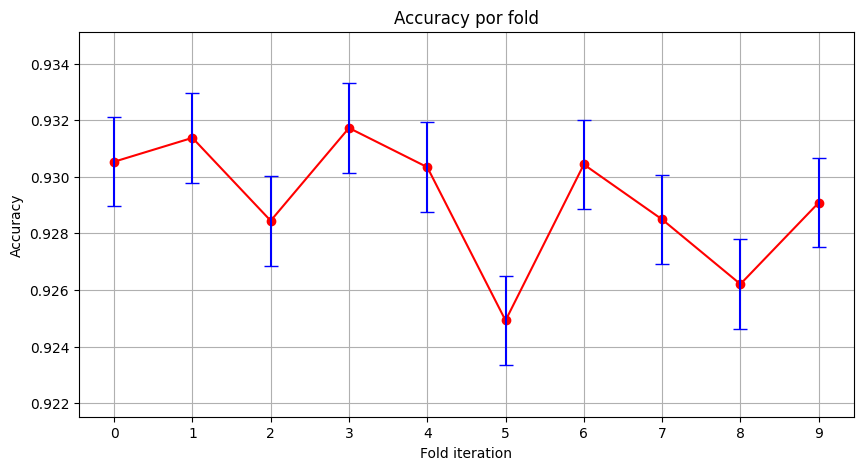

In [269]:
show_accuracy_table(reduced_categories_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(reduced_categories_accuracies, "Accuracy por fold", list(range(10)), "Fold iteration")

## Ejercicio 2

Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de 
aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del
corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes
de tamaño similar. La partición 10 se tomará como test, y las 9 particiones restantes se tomarán
como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus
de entrenamiento, manteniendo fija la partición de test.
Importante: Para esta tarea no es necesario realizar la validación cruzada. 

In [168]:
def accumulated_validation(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    train_data = []
    test_data = partitions[-1]

    accuracies = []
    for i in range(num_partitions-1):
        train_data += partitions[i]

        trainer = hmm.HiddenMarkovModelTagger
        hmm_tagger = trainer.train(train_data)
        acc = hmm_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for number of partitions {i+1}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

Realizar experimentos

In [169]:
accumulated_categories_accuracies = accumulated_validation(cess_sents, 10)

Accuracy for partition 0: 0.7817405177294015
Accuracy for partition 1: 0.8246616231794555
Accuracy for partition 2: 0.8502907724769698
Accuracy for partition 3: 0.8653183058000103
Accuracy for partition 4: 0.87308939323761
Accuracy for partition 5: 0.8805516957439143
Accuracy for partition 6: 0.8870876434563326
Accuracy for partition 7: 0.8925428439092172
Accuracy for partition 8: 0.8984097576038289
Mean accuracy:  0.8615213947929711
Confidence interval:  (0.8325852793701527, 0.8904575102157894)


Mostrar resultados

,Accuracy por number of partitions,Accuracy
0,Number of partitions 1,0.781741
1,Number of partitions 2,0.824662
2,Number of partitions 3,0.850291
3,Number of partitions 4,0.865318
4,Number of partitions 5,0.873089
5,Number of partitions 6,0.880552
6,Number of partitions 7,0.887088
7,Number of partitions 8,0.892543
8,Number of partitions 9,0.89841
9,Confidence interval,0.8326 - 0.8905


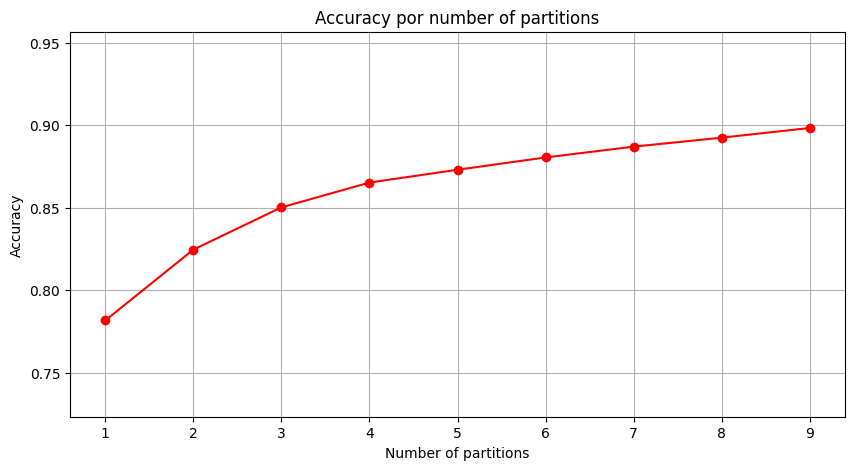

In [270]:
show_accuracy_table(accumulated_categories_accuracies, "Accuracy por number of partitions", ["Number of partitions " + str(i) for i in range(1, 10)], False)
show_accuracy_graph(accumulated_categories_accuracies, "Accuracy por number of partitions", list(range(1, 10)), "Number of partitions", False)

## Ejercicio 3

Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas. 
Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras 
desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría 
morfosintáctica. Este método funciona razonablemente bien para el inglés.

En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en 
cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo 
que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y 
comprobar si aumenta sus prestaciones.

In [177]:
def validate_tnt_suffixes(sentences, affix_length):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    if affix_length != 0:
        tagger = AffixTagger(train_data, affix_length=-affix_length)
    else:
        tagger = tnt.TnT()
        tagger.train(train_data)
    
    accuracy = tagger.accuracy(test_data)

    if affix_length != 0:
        print(f"Accuracy for {affix_length} affix length: {accuracy}")
    else:
        print(f"Accuracy for TnT: {accuracy}")

    return accuracy, tagger

Evaluar diferentes longitudes de sufijo

In [178]:
suffix_lengths = range(10)

suffix_accuracies = []
suffix_models = []
for suffix_length in suffix_lengths:
    acc, model = validate_tnt_suffixes(cess_sents, suffix_length)
    suffix_accuracies.append(acc)
    suffix_models.append(model)

Accuracy for TnT: 0.7533516087144713
Accuracy for 1 affix length: 0.22205629806615396
Accuracy for 2 affix length: 0.24635305119871614
Accuracy for 3 affix length: 0.25706237424547285
Accuracy for 4 affix length: 0.21108952220614266
Accuracy for 5 affix length: 0.1640825606019515
Accuracy for 6 affix length: 0.10525677945071878
Accuracy for 7 affix length: 0.06622279454649396
Accuracy for 8 affix length: 0.04102916308356467
Accuracy for 9 affix length: 0.02333878058323935


Etiquetador TNT con el mejor sufijo encontrado

Best suffix length: 3


,Accuracy per suffix,Accuracy
0,Base TNT,0.753352
1,1 suffixes,0.222056
2,2 suffixes,0.246353
3,3 suffixes,0.257062
4,4 suffixes,0.211090
5,5 suffixes,0.164083
6,6 suffixes,0.105257
7,7 suffixes,0.066223
8,8 suffixes,0.041029
9,9 suffixes,0.023339


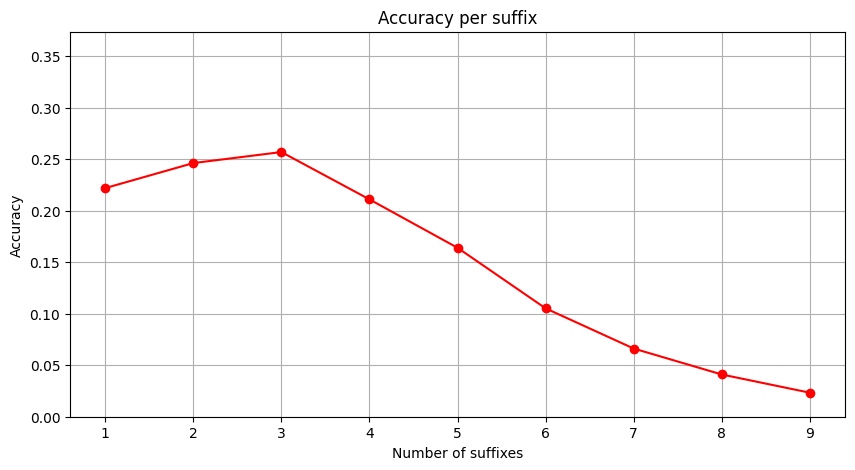

In [271]:
best_sufix_length = np.argmax(suffix_accuracies[1:])
best_suffix_model = suffix_models[best_sufix_length + 1]
print(f"Best suffix length: {best_sufix_length + 1}")

show_accuracy_table(suffix_accuracies, "Accuracy per suffix", ['Base TNT'] + [str(i) + ' suffixes' for i in range(1, len(suffix_accuracies))], True, False)
show_accuracy_graph(suffix_accuracies[1:],  "Accuracy per suffix", [str(i) for i in range(1, len(suffix_accuracies))], "Number of suffixes", False)

Validación del mejor número de sufijos

In [180]:
def cross_validate_tnt_affix(sentences, num_partitions, affix_tagger):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        tnt_tagger = tnt.TnT(unk=affix_tagger, Trained=True)
        tnt_tagger.train(train_data)
        
        accuracy = tnt_tagger.accuracy(test_data)
        accuracies.append(accuracy)
        print(f"Accuracy for partition {i}: {accuracy}")
        
    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

In [181]:
def cross_validate_base_tnt(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        tnt_tagger = tnt.TnT()
        tnt_tagger.train(train_data)
        
        accuracy = tnt_tagger.accuracy(test_data)
        accuracies.append(accuracy)
        print(f"Accuracy for partition {i}: {accuracy}")
        
    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

Best affix tagger with TNT

In [182]:
best_affix_tnt_accuracies = cross_validate_tnt_affix(cess_sents, 10, best_suffix_model)

Accuracy for partition 0: 0.9324710320668284
Accuracy for partition 1: 0.9328772093505416
Accuracy for partition 2: 0.93068122724909
Accuracy for partition 3: 0.9368610625562794
Accuracy for partition 4: 0.9353861686017163
Accuracy for partition 5: 0.9294590831743412
Accuracy for partition 6: 0.934761701218209
Accuracy for partition 7: 0.9299155731868579
Accuracy for partition 8: 0.9295024598062586
Accuracy for partition 9: 0.9302146055272502
Mean accuracy:  0.9322130122737373
Confidence interval:  (0.9302872049733415, 0.9341388195741331)


,Accuracy por fold,Accuracy
0,Fold 0,0.932471
1,Fold 1,0.932877
2,Fold 2,0.930681
3,Fold 3,0.936861
4,Fold 4,0.935386
5,Fold 5,0.929459
6,Fold 6,0.934762
7,Fold 7,0.929916
8,Fold 8,0.929502
9,Fold 9,0.930215


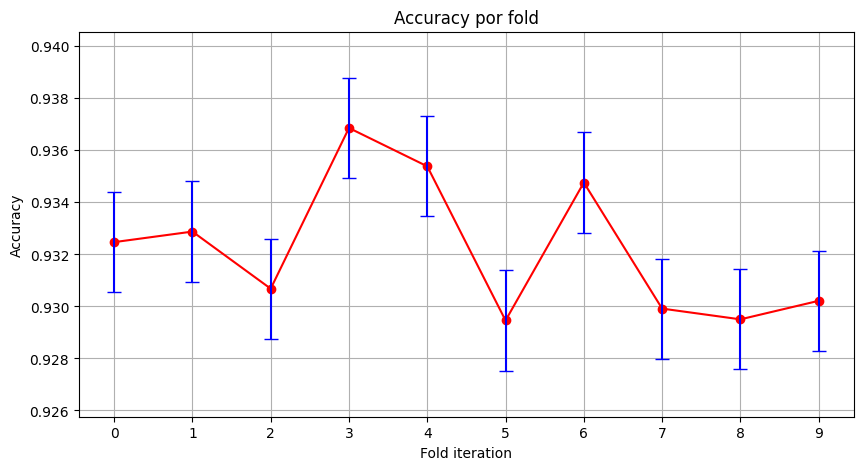

In [272]:
show_accuracy_table(best_affix_tnt_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(best_affix_tnt_accuracies))])
show_accuracy_graph(best_affix_tnt_accuracies, "Accuracy por fold", list(range(len(best_affix_tnt_accuracies))), "Fold iteration")

Base TNT tagger

In [184]:
base_tnt_accuracies = cross_validate_base_tnt(cess_sents, 10)

Accuracy for partition 0: 0.8956076529237402
Accuracy for partition 1: 0.8971129425180118
Accuracy for partition 2: 0.8948517940717629
Accuracy for partition 3: 0.9013718946978124
Accuracy for partition 4: 0.8990913679959617
Accuracy for partition 5: 0.8887743000051564
Accuracy for partition 6: 0.896612524043599
Accuracy for partition 7: 0.8929406977926966
Accuracy for partition 8: 0.8934929248871533
Accuracy for partition 9: 0.8922340589779219
Mean accuracy:  0.8952090157913816
Confidence interval:  (0.8926266621725188, 0.8977913694102443)


,Accuracy por fold,Accuracy
0,Fold 0,0.895608
1,Fold 1,0.897113
2,Fold 2,0.894852
3,Fold 3,0.901372
4,Fold 4,0.899091
5,Fold 5,0.888774
6,Fold 6,0.896613
7,Fold 7,0.892941
8,Fold 8,0.893493
9,Fold 9,0.892234


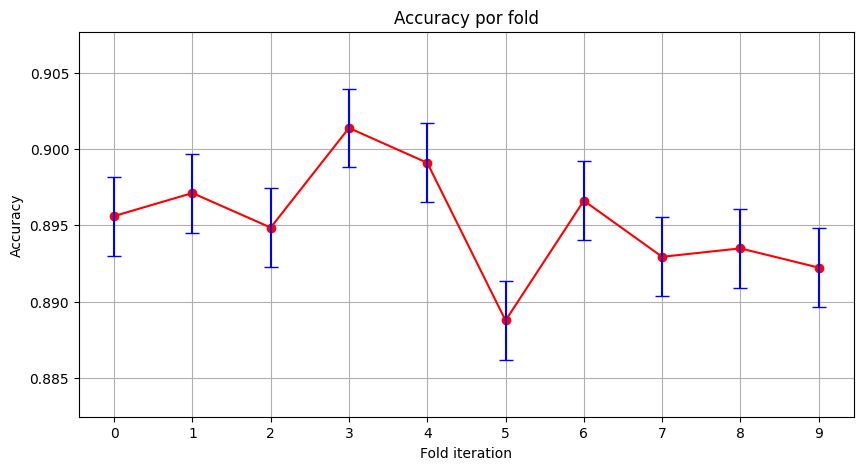

In [273]:
show_accuracy_table(base_tnt_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(base_tnt_accuracies))])
show_accuracy_graph(base_tnt_accuracies, "Accuracy por fold", list(range(len(base_tnt_accuracies))), "Fold iteration")

Comparación

In [229]:
def show_comparison_accuracy_graph(accuracies1, label1, accuracies2, label2, title, labels, x_label):
    plt.figure(figsize=(10, 5))

    acc_mean1 = np.mean(accuracies1)
    conf_int1 = stats.t.interval(0.95, len(accuracies1) - 1, loc=acc_mean1, scale=stats.sem(accuracies1))
    error_y1 = (conf_int1[1] - conf_int1[0]) / 2

    acc_mean2 = np.mean(accuracies2)
    conf_int2 = stats.t.interval(0.95, len(accuracies2) - 1, loc=acc_mean2, scale=stats.sem(accuracies2))
    error_y2 = (conf_int2[1] - conf_int2[0]) / 2

    min_acc = min(min(accuracies1), min(accuracies2))
    max_acc = max(max(accuracies1), max(accuracies2))
    plt.ylim(max(0, min_acc - 0.005), min(1, max_acc + 0.005))
    
    x = list(range(len(accuracies1)))
    plt.plot(x, accuracies1, 'ro-', label=label1)
    plt.plot(x, accuracies2, 'bo-', label=label2)
    
    plt.xticks(x, labels)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    
    plt.errorbar(x, accuracies1, yerr=error_y1, linestyle='None', color='red', capsize=5)
    plt.errorbar(x, accuracies2, yerr=error_y2, linestyle='None', color='blue', capsize=5)

    plt.legend()
    plt.grid(True)
    plt.show()

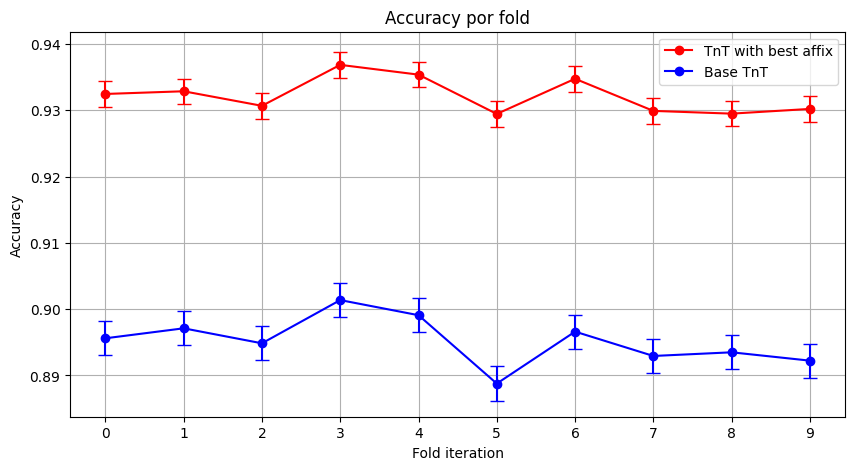

In [230]:
show_comparison_accuracy_graph(best_affix_tnt_accuracies, "TnT with best affix", base_tnt_accuracies, "Base TnT", "Accuracy por fold", list(range(len(best_affix_tnt_accuracies))), "Fold iteration")

## Ejercicio 4

Evaluación del resto de etiquetadores.


Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro 
como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los
etiquetadores tnt y hmm, utilizando el juego de categorías reducido. 

Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo 
probar con Unigram Tagger y con hmm tagger.

La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada 
requiere mucho tiempo

In [188]:
templates = brill.fntbl37()

### Brill

#### Unigram Tagger

Una sola partición

In [189]:
def validate_unigram_bill(sentences):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    unigram_tagger = UnigramTagger(train_data)
    brill_tagger_unigram = brill_trainer.BrillTaggerTrainer(unigram_tagger, templates, deterministic=True)
    brill_tagger_unigram = brill_tagger_unigram.train(train_data)

    accuracy = brill_tagger_unigram.accuracy(test_data)
    print(f"Accuracy: {acc}")

    return accuracy

In [190]:
unigram_bill_accuracy = validate_unigram_bill(reduced_cess_sents)

Accuracy: 0.02333878058323935


Múltiples particiones

In [191]:
def cross_validate_unigram_bill(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        unigram_tagger = UnigramTagger(train_data)
        brill_tagger_unigram = brill_trainer.BrillTaggerTrainer(unigram_tagger, templates, deterministic=True)
        brill_tagger_unigram = brill_tagger_unigram.train(train_data)

        acc = brill_tagger_unigram.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)
    
    return accuracies

In [192]:
unigram_bill_accuracies = cross_validate_unigram_bill(reduced_cess_sents, 10)

Accuracy for partition 0: 0.9047157100511991
Accuracy for partition 1: 0.9051987767584098
Accuracy for partition 2: 0.903588143525741
Accuracy for partition 3: 0.9053975316489221
Accuracy for partition 4: 0.9066128218071681
Accuracy for partition 5: 0.89563244469654
Accuracy for partition 6: 0.903344731780295
Accuracy for partition 7: 0.8983826670735429
Accuracy for partition 8: 0.8992240198813207
Accuracy for partition 9: 0.9000566105707375
Mean accuracy:  0.9022153457793877
Confidence interval:  (0.8996096713922282, 0.9048210201665471)


,Accuracy por fold,Accuracy
0,Fold 0,0.904716
1,Fold 1,0.905199
2,Fold 2,0.903588
3,Fold 3,0.905398
4,Fold 4,0.906613
5,Fold 5,0.895632
6,Fold 6,0.903345
7,Fold 7,0.898383
8,Fold 8,0.899224
9,Fold 9,0.900057


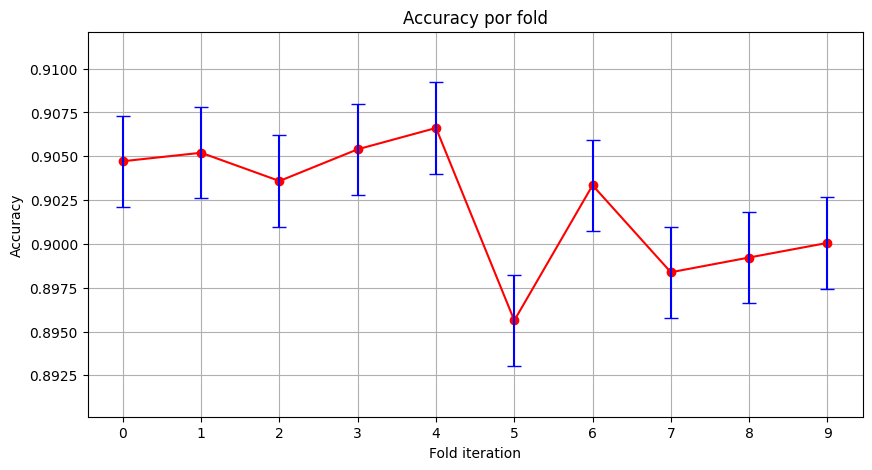

In [274]:
show_accuracy_table(unigram_bill_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(unigram_bill_accuracies))])
show_accuracy_graph(unigram_bill_accuracies, "Accuracy por fold", list(range(len(unigram_bill_accuracies))), "Fold iteration")

#### HNN Tagger

In [194]:
def validate_hnn_bill(sentences):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    hmm_tagger = hmm.HiddenMarkovModelTagger.train(train_data)
    brill_tagger_hmm = brill_trainer.BrillTaggerTrainer(hmm_tagger, templates, deterministic=True)
    brill_tagger_hmm = brill_tagger_hmm.train(train_data)

    accuracy = brill_tagger_hmm.accuracy(test_data)
    print(f"Accuracy: {accuracy}")

Una sola partición

In [195]:
hnn_bill_accuracy = validate_hnn_bill(reduced_cess_sents)

Accuracy: 0.8440327743814355


Múltiples particiones

In [196]:
def cross_validate_hnn_bill(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        hmm_tagger = hmm.HiddenMarkovModelTagger.train(train_data)
        brill_tagger_hmm = brill_trainer.BrillTaggerTrainer(hmm_tagger, templates, deterministic=True)
        brill_tagger_hmm = brill_tagger_hmm.train(train_data)

        acc = brill_tagger_hmm.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)
    return accuracies

In [197]:
hnn_bill_accuracies = cross_validate_hnn_bill(reduced_cess_sents, 10)

Accuracy for partition 0: 0.9337644839665858
Accuracy for partition 1: 0.9368682941999689
Accuracy for partition 2: 0.9329173166926678
Accuracy for partition 3: 0.9342126171937073
Accuracy for partition 4: 0.93331650681474
Accuracy for partition 5: 0.9284277832207497
Accuracy for partition 6: 0.9338533874759564
Accuracy for partition 7: 0.9313904994405452
Accuracy for partition 8: 0.9306182482122026
Accuracy for partition 9: 0.93222170758067
Mean accuracy:  0.9327590844797793
Confidence interval:  (0.9311235103367147, 0.9343946586228439)


,Accuracy por fold,Accuracy
0,Fold 0,0.933764
1,Fold 1,0.936868
2,Fold 2,0.932917
3,Fold 3,0.934213
4,Fold 4,0.933317
5,Fold 5,0.928428
6,Fold 6,0.933853
7,Fold 7,0.93139
8,Fold 8,0.930618
9,Fold 9,0.932222


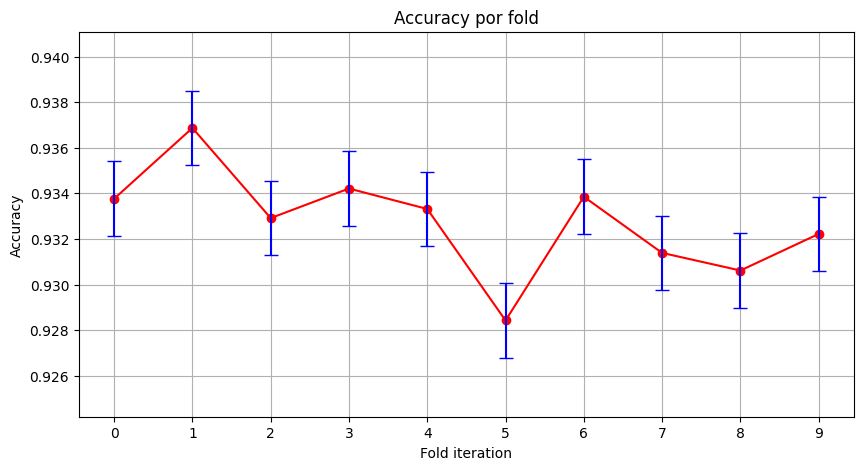

In [275]:
show_accuracy_table(hnn_bill_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(hnn_bill_accuracies))])
show_accuracy_graph(hnn_bill_accuracies, "Accuracy por fold", list(range(len(hnn_bill_accuracies))), "Fold iteration")

### Perceptron

In [199]:
def validate_perceptron(sentences):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    perceptron_tagger = PerceptronTagger(load=False)
    perceptron_tagger.train(train_data)

    accuracy = perceptron_tagger.accuracy(test_data)
    print(f"Accuracy: {accuracy}")

    return accuracy

Una partición

In [200]:
perceptron_accuracy = validate_perceptron(reduced_cess_sents)

Accuracy: 0.9245351657235247


Múltiples particiones

In [201]:
def cross_validate_perceptron(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        perceptron_tagger = PerceptronTagger(load=False)
        perceptron_tagger.train(train_data)

        acc = perceptron_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)
    return accuracies

In [202]:
perceptron_accuracies = cross_validate_perceptron(reduced_cess_sents, 10)

Accuracy for partition 0: 0.9669630827270278
Accuracy for partition 1: 0.9701446120354533
Accuracy for partition 2: 0.9696307852314092
Accuracy for partition 3: 0.9724561682292494
Accuracy for partition 4: 0.9701161029782938
Accuracy for partition 5: 0.9690094363945754
Accuracy for partition 6: 0.9693844838640735
Accuracy for partition 7: 0.9683145153087174
Accuracy for partition 8: 0.9677435715372521
Accuracy for partition 9: 0.9675261180587721
Mean accuracy:  0.9691288876364824
Confidence interval:  (0.9679791006592611, 0.9702786746137038)


,Accuracy por fold,Accuracy
0,Fold 0,0.966963
1,Fold 1,0.970145
2,Fold 2,0.969631
3,Fold 3,0.972456
4,Fold 4,0.970116
5,Fold 5,0.969009
6,Fold 6,0.969384
7,Fold 7,0.968315
8,Fold 8,0.967744
9,Fold 9,0.967526


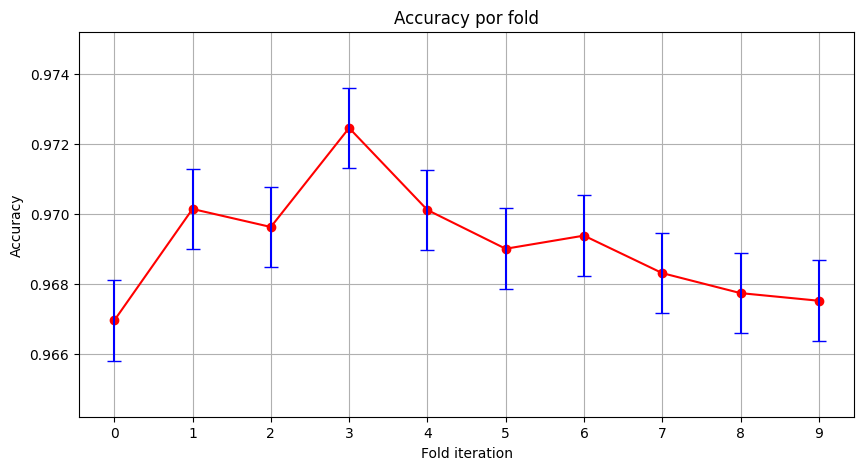

In [276]:
show_accuracy_table(perceptron_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(perceptron_accuracies))])
show_accuracy_graph(perceptron_accuracies, "Accuracy por fold", list(range(len(perceptron_accuracies))), "Fold iteration")